In [1]:
!pip install -U -q tensorflow tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.8 MB/s eta 0:00:00


## Setup

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the mini Speech Commands dataset

In [4]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
     'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'yes' 'stop' 'no' 'go' 'up' 'left' 'down']


In [8]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [11]:
for data, label in train_ds.take(1):
  print(data)
  print(label)
  break

tf.Tensor(
[[[ 1.6784668e-03]
  [ 8.8500977e-04]
  [ 1.0375977e-03]
  ...
  [-5.4626465e-03]
  [-5.3710938e-03]
  [-6.9274902e-03]]

 [[-3.9672852e-04]
  [-6.7138672e-04]
  [-4.8828125e-04]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]]

 [[-3.0517578e-05]
  [-3.0517578e-05]
  [ 3.0517578e-05]
  ...
  [ 2.1362305e-04]
  [ 2.1362305e-04]
  [ 4.2724609e-04]]

 ...

 [[-1.0375977e-03]
  [-2.4414062e-03]
  [-3.2958984e-03]
  ...
  [-4.3640137e-03]
  [-3.5705566e-03]
  [-3.6926270e-03]]

 [[ 6.1035156e-05]
  [ 0.0000000e+00]
  [-3.0517578e-05]
  ...
  [ 9.7656250e-04]
  [ 8.2397461e-04]
  [ 8.8500977e-04]]

 [[-4.5776367e-04]
  [-4.8828125e-04]
  [-5.1879883e-04]
  ...
  [ 7.9345703e-04]
  [ 6.1035156e-04]
  [ 6.4086914e-04]]], shape=(64, 16000, 1), dtype=float32)
tf.Tensor(
[4 3 7 2 4 4 5 3 5 1 4 5 7 2 5 2 0 7 5 2 0 0 3 0 6 2 4 3 0 3 4 2 0 2 2 0 5
 7 5 3 3 6 1 5 5 0 4 3 5 1 5 7 3 2 7 4 6 3 5 6 1 3 2 3], shape=(64,), dtype=int32)


In [12]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [13]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, label

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [15]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [16]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [17]:
label_names[[1, 1, 3, 0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

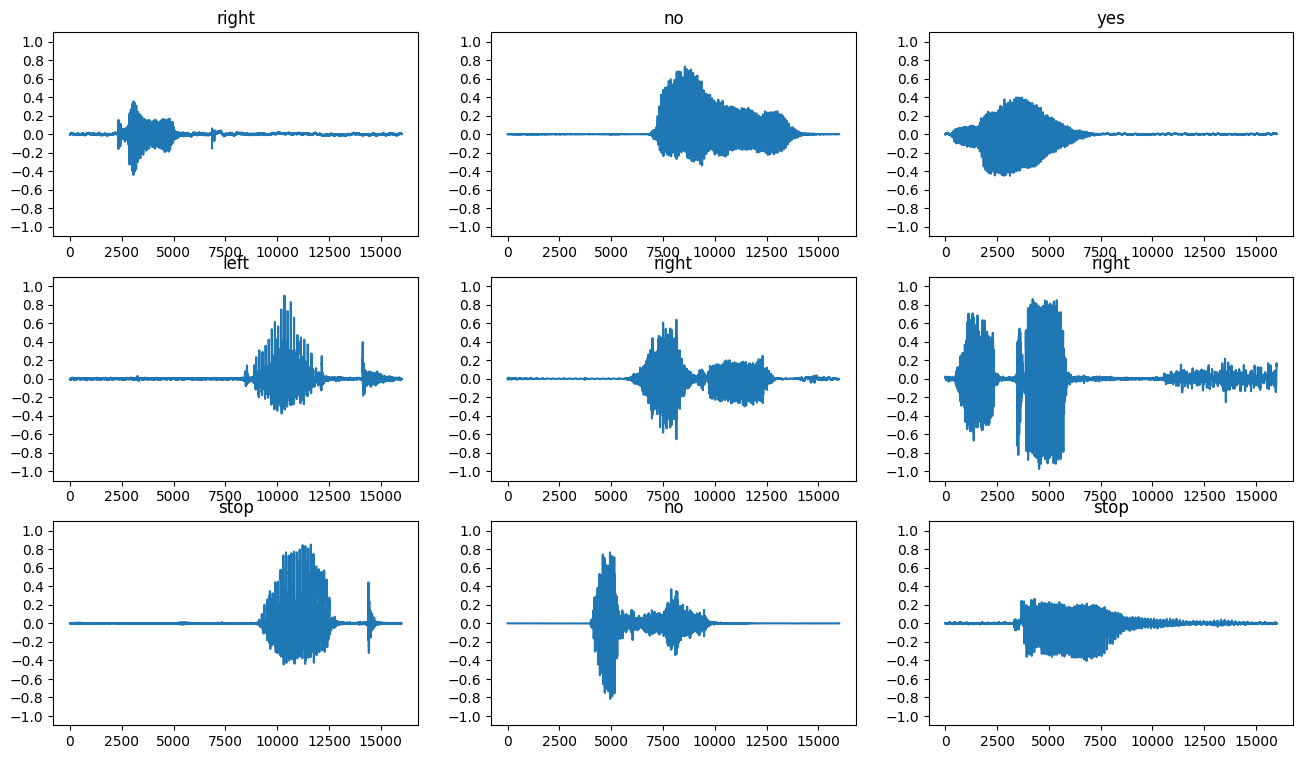

In [25]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i >= n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1, 1.1])

plt.show()

In [26]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [28]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [29]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

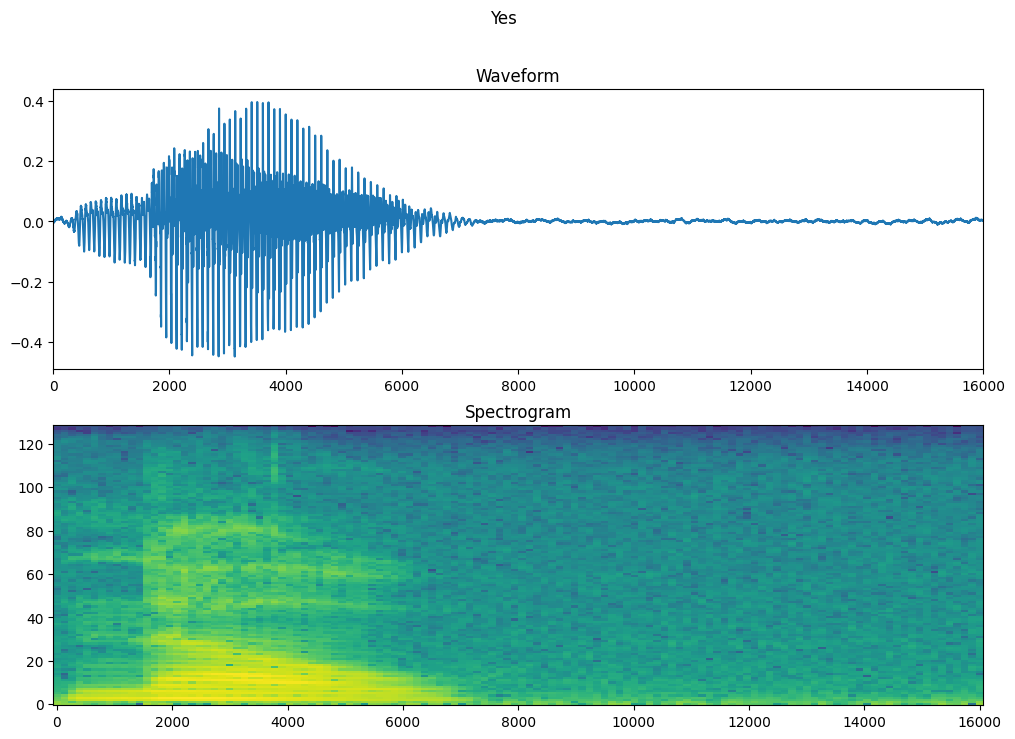

In [31]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [32]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio, label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [33]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [36]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

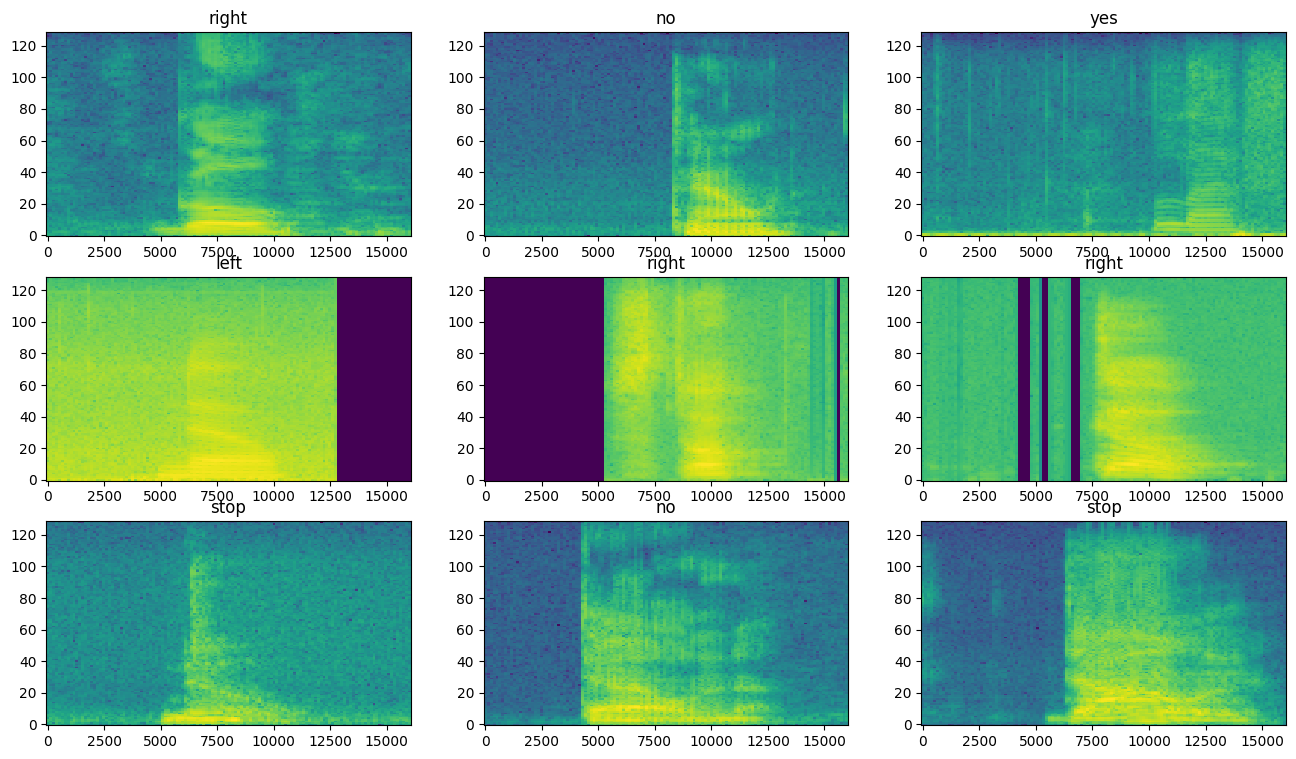

In [37]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(example_spectrograms[i].numpy(), ax)
  ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(AUTOTUNE)

In [40]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize
    norm_layer,
    layers.Conv2D(32, 3, activation="relu"),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation="softmax")
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [41]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [42]:
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=10
)

Epoch 1/10
100/100 [==============================] - 39s 355ms/step - loss: 2.0260 - accuracy: 0.1828 - val_loss: 2.0085 - val_accuracy: 0.1810
Epoch 2/10
100/100 [==============================] - 31s 312ms/step - loss: 2.0064 - accuracy: 0.1934 - val_loss: 2.0173 - val_accuracy: 0.1836
Epoch 3/10
100/100 [==============================] - 38s 379ms/step - loss: 1.9870 - accuracy: 0.2081 - val_loss: 2.0383 - val_accuracy: 0.1901
Epoch 4/10
100/100 [==============================] - 26s 261ms/step - loss: 1.9555 - accuracy: 0.2270 - val_loss: 2.0398 - val_accuracy: 0.1979
Epoch 5/10
100/100 [==============================] - 23s 232ms/step - loss: 1.9071 - accuracy: 0.2495 - val_loss: 2.0633 - val_accuracy: 0.1914
Epoch 6/10
100/100 [==============================] - 26s 257ms/step - loss: 1.8443 - accuracy: 0.2884 - val_loss: 2.1086 - val_accuracy: 0.1992
Epoch 7/10
100/100 [==============================] - 26s 259ms/step - loss: 1.7834 - accuracy: 0.3105 - val_loss: 2.1335 - val_ac

Text(0, 0.5, 'Accuracy [%]')

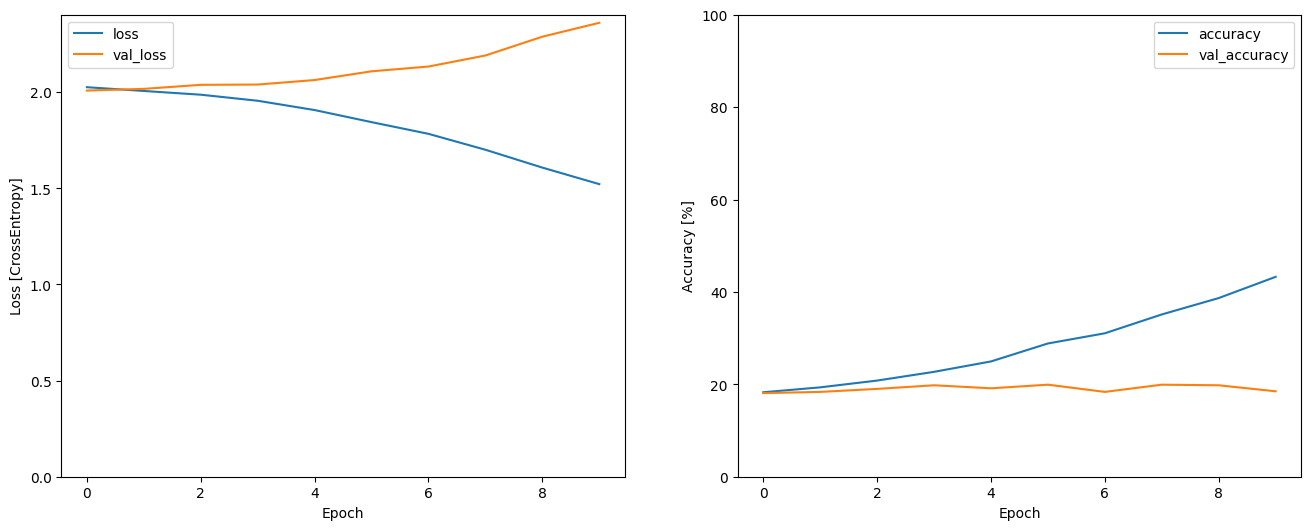

In [43]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [44]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 2s 149ms/step - loss: 2.4054 - accuracy: 0.1683


{'loss': 2.4053831100463867, 'accuracy': 0.16826923191547394}

In [45]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 1s 47ms/step


In [46]:
y_pred = tf.argmax(y_pred, axis=1)

In [47]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

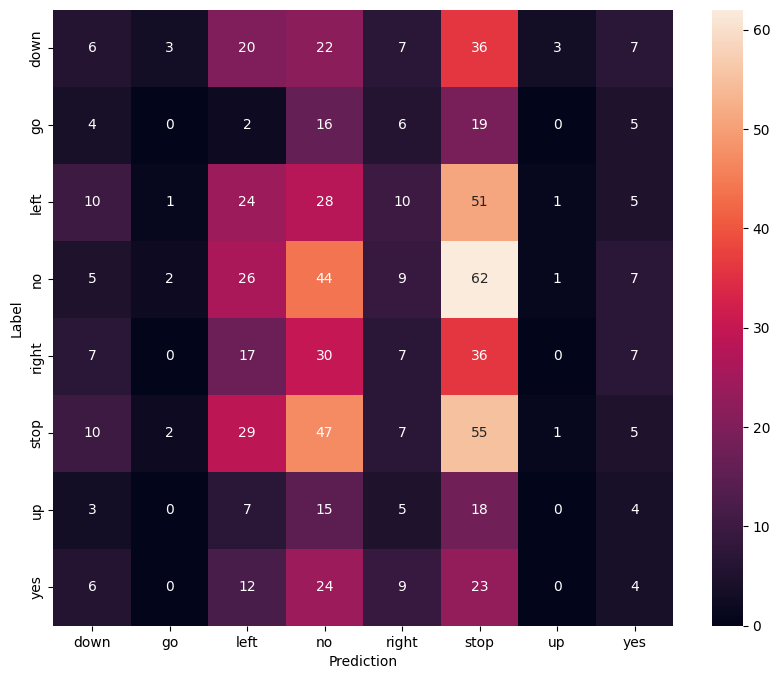

In [48]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

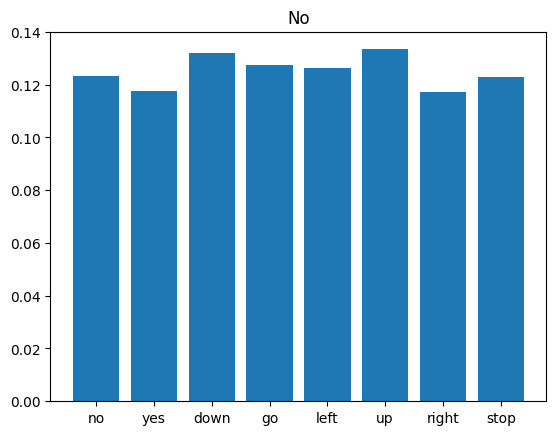

In [49]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))